In [1]:
%cd /home/rosneft_user_2500/anomaly-detection/
# %cd ..

/home/rosneft_user_2500/anomaly-detection


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import interact

import cufflinks as cf
cf.go_offline(connected=True)

import bokeh.io
bokeh.io.output_notebook()

np.random.seed(42)

Loading BokehJS ...

In [3]:
root_folder = %pwd
import sys
sys.path = [root_folder] + sys.path

In [4]:
import matplotlib.pyplot as plt

def compare_plot_1d(real, real_lbl, pred, pred_lbl, shift_pred=0):
    plt.plot(real, label=real_lbl, alpha=0.7)
    plt.plot(list(range(shift_pred, real.shape[0])), pred, label=pred_lbl, alpha=0.8)
    plt.legend()

def compare_plot_from_2d(real, real_lbl, pred, pred_lbl, component, shift_pred=0):
    real_comp = real[:, component]
    pred_comp = pred[:, component]
    compare_plot_1d(real_comp,real_lbl, pred_comp, pred_lbl, shift_pred)
    
def compare_plot_from_2d_wrapper(*args, **kwargs):
    def f(**inner_kwargs):
        return compare_plot_from_2d(*args, **kwargs, **inner_kwargs)
    return f

def interactive_plotter_by_component(funcs, titles, suptitle):
    @interact(component=(0, data.shape[1]-1))
    def __inner__(component):
        plt.figure(figsize=(18, 8))
        plt.suptitle(suptitle)
        for i, (func, title) in enumerate(zip(funcs, titles), 1):
            plt.subplot(1, len(funcs), i)
            plt.title(title)
            func(component=component)

# Загрузка и обработка данных

In [60]:
from sklearn.model_selection import train_test_split
from src.features.build_features import rolling_window

prediction_len = 1
window_len = 64

# batch size need to be equal with window len
# due fact, that i-th example in current batch need to get states
# of i-th example of previous batch
batch_size = window_len

data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


## Разложение в тренд и сезонную компоненту

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf

interact(lambda component: plot_acf(data.values[:, component], lags=np.arange(0, 2000)),
         component=(0, 40))

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

<function __main__.<lambda>(component)>

In [7]:
import statsmodels.tsa.seasonal as seasonal
period = 750
decomposed = seasonal.seasonal_decompose(data.values,
                                         period=period,
                                         extrapolate_trend='freq')


@interact(comp=(0, 40))
def f(comp):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title('Trend')
    plt.plot(decomposed.trend[:, comp])
    plt.subplot(1, 2, 2)
    plt.title('Seasonal')
    plt.plot(decomposed.seasonal[:, comp])

interactive(children=(IntSlider(value=20, description='comp', max=40), Output()), _dom_classes=('widget-intera…

## Интерполяция

In [8]:
from scipy.interpolate import interp1d

n = 5000
step = 50

def interp(component):
    f = interp1d(np.arange(0, decomposed.trend.shape[0], step),
                 decomposed.trend[::step, component], kind='cubic')
    plt.plot(f(np.arange(n)))

interactive_plotter_by_component([
    lambda component: plt.plot(decomposed.trend[:n, component], label='x'),
    interp,
], ['Original', 'Interpolated'], None)

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

In [9]:
f = interp1d(np.arange(0, data.shape[0], step),
             decomposed.trend[::step],
             axis=0,
             kind='cubic')
trend_data = f(np.arange(data.shape[0]))

# LSTM

In [10]:
from datetime import datetime
import torch
from src.models.prediction import LSTM, Trainer

def get_log_path(name):
    return name + '_' + datetime.now().strftime('%Y-%m-%d-%H-%M')

In [14]:
def forecast_tr_te(model, X_tr, X_te, batch_size):
    """
    If len(X) is not divideble to batch_size, then first len(X) % batch_size will
    not propagate states. It is as if we start forecasting from len(X) % batch_size
    element from X
    """
    model.reset_states()
    reminder = len(X_tr) % batch_size
    tmp_pred = torch.zeros((reminder, model.linear.out_features))
    if reminder:
        tmp_pred = model.forecast(X_tr[:reminder], reminder)
        model.reset_states()
    train_pred = model.forecast(X_tr[reminder:], batch_size)
    train_pred = torch.cat([tmp_pred, train_pred], dim=0)
    test_pred = model.forecast(X_te, batch_size)
    return train_pred, test_pred

## Тренд

In [11]:
from src.utils import to_torch_dataloader

def get_dataloader(data, window_len):
    """
    Batch size must be equal with window len
    due fact, that i-th example in current batch need to get states
    of i-th example of previous batch
    """
    X = rolling_window(data, window_len)[:-prediction_len]
    y = rolling_window(data, prediction_len, window_len)

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.7, shuffle=False)
    
    train_set = to_torch_dataloader(X_tr, y_tr, dict(batch_size=window_len))
    test_set = to_torch_dataloader(X_te, y_te, dict(batch_size=window_len))
    return train_set, test_set

In [12]:
train_set, test_set = get_dataloader(trend_data, window_len)

### HP search

In [ ]:
# # HP search
# !pip install tabulate
# !pip install ray
# !pip install ray[tune]

In [14]:
from ray import tune
from ray.tune import track

In [18]:
device = torch.device('cpu')
criterion = torch.nn.MSELoss()

import copy
def evaluate(config):
    config = copy.deepcopy(config)
    train_set, test_set = get_dataloader(trend_data, int(config['window_len']))
    del config['window_len']
    
    weight_decay = float(config['weight_decay'])
    del config['weight_decay']
    config['input_size'] = data.shape[1]
    config['batch_first'] = True

    # see: https://discuss.pytorch.org/t/error-with-lstm-when-switching-from-0-4-to-1-0-invalid-combination-of-arguments/35629/5
    config['hidden_size'] = int(config['hidden_size'])
    config['num_layers'] = int(config['num_layers'])
    config['bidirectional'] = bool(config['bidirectional'])
    
    model = LSTM(**config).to(device)
    optim = torch.optim.Adam(model.parameters(), weight_decay=float(weight_decay))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                           patience=3,
                                                           threshold=0.01)

    trainer = Trainer(
        model,
        criterion,
        optim,
        scheduler,
        device,
        get_log_path(
            f'logs/trend'
        ),
        stateful=True,
        hparams=config)
    
    trainer.train(train_set, test_set, 15)
    track.log(loss=trainer.best_loss)

In [ ]:
config = dict(
    window_len=tune.choice([32, 48, 64]),
    hidden_size=tune.choice([8, 12]),
    num_layers=tune.choice([2, 3]),
    bidirectional=tune.choice([False, True]),
    weight_decay=tune.uniform(0.0005, 0.01),
)

analysis = tune.run(evaluate, config=config, num_samples=20)

In [57]:
resdf = analysis.dataframe()
resdf.sort_values('loss').head()

,loss,trial_id,training_iteration,time_this_iter_s,done,timesteps_total,episodes_total,experiment_id,date,timestamp,...,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config/bidirectional,config/hidden_size,config/num_layers,config/weight_decay,config/window_len,logdir
12,0.039795,12,0,573.908032,False,NaN,NaN,7f3d4f40d0284eb7ba95745b05173567,2020-04-10_19-46-21,1586537181,...,573.908032,0,1,"12_bidirectional=True,hidden_size=12,num_layer...",True,12,2,0.000647,32,/home/rosneft_user_2500/ray_results/evaluate/e...
1,0.048548,1,0,308.478910,False,NaN,NaN,589d45124f9f4ce2a4d6da6a68537290,2020-04-10_19-41-52,1586536912,...,308.478910,0,1,"1_bidirectional=False,hidden_size=8,num_layers...",False,8,2,0.000548,48,/home/rosneft_user_2500/ray_results/evaluate/e...
0,0.060433,0,0,811.679555,False,NaN,NaN,ca6f8d204374415fab5c3f373b04454c,2020-04-10_19-50-15,1586537415,...,811.679555,0,1,"0_bidirectional=True,hidden_size=12,num_layers...",True,12,3,0.000587,48,/home/rosneft_user_2500/ray_results/evaluate/e...
3,0.066465,3,0,423.922788,False,NaN,NaN,6472a2e6817f4b9e9c9959bfc8681915,2020-04-10_19-43-48,1586537028,...,423.922788,0,1,"3_bidirectional=False,hidden_size=8,num_layers...",False,8,3,0.000672,32,/home/rosneft_user_2500/ray_results/evaluate/e...
9,0.074381,9,0,349.287980,False,NaN,NaN,c8a26bbd5ae64789afd6807dc2721796,2020-04-10_19-42-35,1586536955,...,349.287980,0,1,"9_bidirectional=False,hidden_size=12,num_layer...",False,12,2,0.002687,64,/home/rosneft_user_2500/ray_results/evaluate/e...


In [58]:
resdf['loss'].min()

0.03979526917201923

### Обучение

In [63]:
config = dict(
    input_size=data.shape[1],
    hidden_size=16,
    num_layers=1,
    batch_first=True,
    bidirectional=True,
)

device = torch.device('cpu')
model = LSTM(**config).to(device)
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                       patience=3,
                                                       threshold=0.01)

trainer = Trainer(
    model,
    criterion,
    optim,
    scheduler,
    device,
    get_log_path(
        f'logs/trend-interpolated'
    ),
    stateful=True,
    hparams=config)

In [ ]:
train_set, test_set = get_data(window_len)
trainer.train(train_set, test_set, 20)

Epoch 0 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.582]

Epoch 0/19
----------


Epoch 1 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.437]

Loss: 0.1295

Epoch 1/19
----------


Epoch 4 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.247]

Loss: 0.0580

Epoch 4/19
----------


Epoch 5 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.241]

Loss: 0.0569

Epoch 5/19
----------


Epoch 6 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.263]

Loss: 0.0583

Epoch 6/19
----------


Epoch 7 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.202]

Loss: 0.0527

Epoch 7/19
----------


Epoch 8 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.224]

Loss: 0.0592

Epoch 8/19
----------


Epoch 9 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.189]

Loss: 0.0492

Epoch 9/19
----------


Epoch 10 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.184]

Loss: 0.0495

Epoch 10/19
----------


Epoch 11 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.168]

Loss: 0.0466

Epoch 11/19
----------


Epoch 12 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.155]

Loss: 0.0454

Epoch 12/19
----------


Epoch 13 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.143]

Loss: 0.0440

Epoch 13/19
----------


Epoch 14 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.168]

Loss: 0.0480

Epoch 14/19
----------


Epoch 15 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.13]

Loss: 0.0469

Epoch 15/19
----------


Epoch 16 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.17]

Loss: 0.0551

Epoch 16/19
----------


Epoch 16 of train: :  50%|█████     | 70/140 [00:17<00:17,  3.99it/s, loss=0.0354] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 19 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.116]

Loss: 0.0433

Epoch 19/19
----------


Epoch 19 of val: :  75%|███████▌  | 45/60 [00:11<00:04,  3.64it/s, loss=0.0242]

In [21]:
torch.save(model, 'models/trend.pth')

### Предсказание

In [13]:
import torch
model = torch.load('models/trend.pth')

/home/rosneft_user_2500/anaconda3/envs/anom-det/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning:

source code of class 'src.models.prediction.models.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.



In [15]:
X_tr, y_tr = train_set.dataset.tensors
X_te, y_te = test_set.dataset.tensors

In [16]:
train_pred, test_pred = forecast_tr_te(model, X_tr, X_te, window_len)

train_pred = train_pred.detach().numpy()
test_pred = test_pred.detach().numpy()

  0%|          | 0/1 [00:00<?, ?it/s]/home/rosneft_user_2500/anomaly-detection/src/models/prediction/models.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  0%|          | 0/139 [00:00<?, ?it/s]/home/rosneft_user_2500/anomaly-detection/src/models/prediction/models.py:47: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 60/60 [00:02<00:00, 29.55it/s]


In [17]:
split_point = len(X_tr) + window_len

interactive_plotter_by_component([
    compare_plot_from_2d_wrapper(trend_data[:split_point],
                                 'real',
                                 train_pred,
                                 'pred',
                                 shift_pred=window_len),
    compare_plot_from_2d_wrapper(trend_data[split_point:], 'real',
                                 test_pred, 'pred')
], ['Train', 'Test'], 'Next value prediction of trend')

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

#### Weighted MSE - Optional

На некоторых компонентах плохое предсказание, поэтому им нужно получить больше веса

In [18]:
# from sklearn.metrics import mean_squared_error

# width = 3000
# err = mean_squared_error(test_pred[:width], decomposed.trend[split_point:split_point+width], multioutput='raw_values')
# plt.bar(np.arange(len(err)), err)

# def weighted_mse_loss(weights):
#     weights = torch.tensor(weights)
#     criterion = torch.nn.MSELoss(reduction='none')
#     def mse(input, target):
#         nonlocal weights, criterion
#         loss = criterion(input, target)
#         loss = loss * weights.expand_as(loss)
#         return loss.mean()
#     return mse

# criterion = weighted_mse_loss(err / err.sum())
# optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
#                                                        patience=3,
#                                                        threshold=0.01)

# trainer = Trainer(
#     model,
#     criterion,
#     optim,
#     scheduler,
#     device,
#     get_log_path(
#         f'logs/trend-retraining-{config["num_layers"]}-layers-{config["hidden_size"]}-hidden-{window_len}-len'
#     ),
#     stateful=True)



# model.reset_states()
# trainer.train(train_set, test_set, 10)

# model.reset_states()
# split_point = len(X_tr) + window_len
# train_pred = next_value_prediction(model, decomposed.trend[:split_point],
#                                    window_len)
# test_pred = next_value_prediction(model, decomposed.trend[split_point:],
#                                   window_len)

# train_pred = train_pred.detach().numpy()
# test_pred = test_pred.detach().numpy()

## Предсказание остатков

### Подоготвка данных 

In [18]:
train_resid = np.array(y_tr).squeeze() - train_pred
test_resid = np.array(y_te).squeeze() - test_pred

trend_pred = np.r_[train_pred, test_pred]
residuals = np.r_[train_resid, test_resid]

In [19]:
interactive_plotter_by_component([
    compare_plot_from_2d_wrapper(decomposed.trend,
                                 'real',
                                 trend_pred,
                                 'Next value prediction (LSTM)',
                                 shift_pred=window_len),
    lambda component: plt.plot(residuals[:, component], label='Residuals (data - trend_pred)')
],
['Trend', 'Resid'], None)

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

In [20]:
from scipy.ndimage import gaussian_filter1d
@interact(component=(0, 40), sigma=np.arange(1, 11))
def plot(component, sigma):
    smoothed = gaussian_filter1d(train_resid, sigma, axis=0)
    pd.DataFrame(dict(component=smoothed[:, component])).iplot()

interactive(children=(IntSlider(value=20, description='component', max=40), Dropdown(description='sigma', opti…

In [21]:
sigma = 10
smoothed_train = gaussian_filter1d(train_resid, sigma, axis=0)
smoothed_test = gaussian_filter1d(test_resid, sigma, axis=0)

In [22]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler().fit(train_resid)
# train_resid_scaled = ss.transform(smoothed_train)
# test_resid_scaled = ss.transform(smoothed_test)

### Обучение

In [28]:
# def get_data_with_states(data, residuals, window_len):
#     """
#     Data must be a shape (n, d)
#     Residuals must be a shape (n-window_len, d)
#     """
#     additional_dim_data = torch.tensor(data[None, ...]).float()
#     out, _ = model.lstm(additional_dim_data)
#     out = out.permute(1, 0, 2).view(out.size(1), -1).detach().numpy()
#     data = np.c_[data, out]
#     X = rolling_window(data, window_len)[:-prediction_len]
    
#     X_tr, X_te, y_tr, y_te = train_test_split(X, residuals, train_size=0.7, shuffle=False)
    
#     train_set = to_torch_dataloader(X_tr, y_tr, dict(batch_size=window_len))
#     test_set = to_torch_dataloader(X_te, y_te, dict(batch_size=window_len))
#     return train_set, test_set

# train_set, test_set = get_data_with_states(data.values, residuals, window_len)

train_set = to_torch_dataloader(X_tr, smoothed_train, dict(batch_size=batch_size))
test_set = to_torch_dataloader(X_te, smoothed_test, dict(batch_size=batch_size))

/home/rosneft_user_2500/anomaly-detection/src/utils.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [29]:
import torch
from src.models.prediction import LSTM, Trainer

config = dict(
    input_size=train_set.dataset.tensors[0].shape[-1],
    output_size=train_set.dataset.tensors[1].shape[-1],
    hidden_size=16,
    num_layers=1,
    batch_first=True,
    bidirectional=True,
)

device = torch.device('cpu')
resid_model = LSTM(**config).to(device)
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(resid_model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                       patience=3,
                                                       threshold=0.01)

trainer = Trainer(
    resid_model,
    criterion,
    optim,
    scheduler,
    device,
    get_log_path(
        f'logs/resid-smoothed'
    ),
    config,
    stateful=True,
)

In [30]:
trainer.train(train_set, test_set, 20)

Epoch 0 of train: :   1%|          | 1/140 [00:00<00:18,  7.62it/s, loss=0.0968]

Epoch 0/19
----------


/home/rosneft_user_2500/anomaly-detection/src/models/prediction/models.py:47: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Epoch 1 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.0244]

Loss: 0.0229

Epoch 1/19
----------


Epoch 2 of train: :   1%|          | 1/140 [00:00<00:14,  9.54it/s, loss=0.0183]

Loss: 0.0210

Epoch 2/19
----------


Epoch 3 of train: :   1%|          | 1/140 [00:00<00:14,  9.51it/s, loss=0.0151]

Loss: 0.0201

Epoch 3/19
----------


Epoch 4 of train: :   1%|          | 1/140 [00:00<00:15,  8.98it/s, loss=0.0138]

Loss: 0.0195

Epoch 4/19
----------


Epoch 5 of train: :   1%|          | 1/140 [00:00<00:16,  8.20it/s, loss=0.0131]

Loss: 0.0193

Epoch 5/19
----------


Epoch 6 of train: :   1%|          | 1/140 [00:00<00:13,  9.95it/s, loss=0.0127]

Loss: 0.0191

Epoch 6/19
----------


Epoch 7 of train: :   1%|          | 1/140 [00:00<00:15,  9.21it/s, loss=0.0125]

Loss: 0.0190

Epoch 7/19
----------


Epoch 8 of train: :   1%|          | 1/140 [00:00<00:14,  9.81it/s, loss=0.0123]

Loss: 0.0190

Epoch 8/19
----------


Epoch 9 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.0123]

Loss: 0.0191

Epoch 9/19
----------


Epoch 10 of train: :   1%|          | 1/140 [00:00<00:13,  9.95it/s, loss=0.0122]

Loss: 0.0192

Epoch 10/19
----------


Epoch 11 of train: :   1%|          | 1/140 [00:00<00:18,  7.54it/s, loss=0.0127]

Loss: 0.0193

Epoch 11/19
----------


Epoch 12 of train: :   1%|          | 1/140 [00:00<00:13,  9.94it/s, loss=0.0128]

Loss: 0.0200

Epoch 12/19
----------


Epoch 13 of train: :   1%|          | 1/140 [00:00<00:14,  9.29it/s, loss=0.012] 

Loss: 0.0201

Epoch 13/19
----------


Epoch 14 of train: :   1%|          | 1/140 [00:00<00:15,  9.02it/s, loss=0.0112]

Loss: 0.0202

Epoch 14/19
----------


Epoch 15 of train: :   1%|          | 1/140 [00:00<00:14,  9.62it/s, loss=0.0107]

Loss: 0.0203

Epoch 15/19
----------


Epoch 16 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.0106]

Loss: 0.0203

Epoch 16/19
----------


Epoch 17 of train: :   1%|          | 1/140 [00:00<00:16,  8.56it/s, loss=0.0106]

Loss: 0.0203

Epoch 17/19
----------


Epoch 18 of train: :   1%|▏         | 2/140 [00:00<00:13, 10.08it/s, loss=0.0105]

Loss: 0.0203

Epoch 18/19
----------


Epoch 19 of train: :   0%|          | 0/140 [00:00<?, ?it/s, loss=0.0105]

Loss: 0.0203

Epoch 19/19
----------


Epoch 19 of val: : 100%|██████████| 60/60 [00:06<00:00,  8.77it/s, loss=0.131]  


Loss: 0.0203



In [31]:
torch.save(resid_model, 'models/resid.pth')

### Prediction

In [32]:
resid_model = torch.load('models/resid.pth')
resid_model.reset_states()

train_resid_pred, test_resid_pred = forecast_tr_te(
    resid_model, train_set.dataset.tensors[0], test_set.dataset.tensors[0],
    batch_size)

  0%|          | 0/1 [00:00<?, ?it/s]/home/rosneft_user_2500/anomaly-detection/src/models/prediction/models.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 60/60 [00:01<00:00, 30.93it/s]


In [33]:
train_resid_pred = train_resid_pred.detach().numpy()
test_resid_pred = test_resid_pred.detach().numpy()

In [34]:
interactive_plotter_by_component([
    compare_plot_from_2d_wrapper(np.r_[train_resid_pred, test_resid_pred],
                                 'Next value prediction (LSTM)',
                                 np.r_[smoothed_train, smoothed_test],
                                 'Residuals (data - trend_pred)')
], ['Residuals'], None)

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

#### Optional - Weighted MSE by component. Refitting

<BarContainer object of 41 artists>

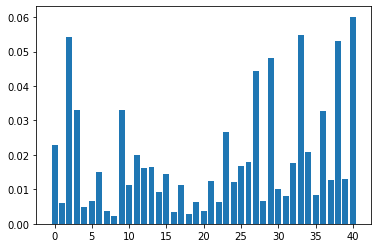

In [35]:
from sklearn.metrics import mean_squared_error

err = mean_squared_error(test_resid_pred, smoothed_test, multioutput='raw_values')
plt.bar(np.arange(len(err)), err)

In [36]:
def weighted_mse_loss(weights):
    weights = torch.tensor(weights)
    criterion = torch.nn.MSELoss(reduction='none')
    def mse(input, target):
        nonlocal weights, criterion
        loss = criterion(input, target)
        loss = loss * weights.expand_as(loss)
        return loss.mean()
    return mse

In [44]:
criterion = weighted_mse_loss(err / err.sum() * len(err))
optim = torch.optim.Adam(resid_model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                       patience=3,
                                                       threshold=0.01)

trainer = Trainer(
    resid_model,
    criterion,
    optim,
    scheduler,
    device,
    get_log_path(
        f'logs/resid-refit'
    ),
    config,
    stateful=True)

In [45]:
resid_model.reset_states()
trainer.train(train_set, test_set, 10)

Epoch 0 of train: :   1%|          | 1/140 [00:00<00:24,  5.57it/s, loss=0.0903]

Epoch 0/9
----------


Epoch 1 of train: :   1%|          | 1/140 [00:00<00:19,  7.11it/s, loss=0.0292]

Loss: 0.0340

Epoch 1/9
----------


Epoch 2 of train: :   1%|          | 1/140 [00:00<00:21,  6.60it/s, loss=0.0774]

Loss: 0.0347

Epoch 2/9
----------


Epoch 3 of train: :   1%|          | 1/140 [00:00<00:16,  8.48it/s, loss=0.0256]

Loss: 0.0347

Epoch 3/9
----------


Epoch 4 of train: :   1%|          | 1/140 [00:00<00:15,  8.80it/s, loss=0.025] 

Loss: 0.0347

Epoch 4/9
----------


Epoch 5 of train: :   1%|          | 1/140 [00:00<00:17,  8.06it/s, loss=0.0264]

Loss: 0.0348

Epoch 5/9
----------


Epoch 6 of train: :  91%|█████████▏| 128/140 [00:14<00:01,  8.57it/s, loss=0.00767]


KeyboardInterrupt: 

In [ ]:
# torch.save(resid_model, 'models/resid_refit.pth')

In [ ]:
# model.reset_states()
# split_point = len(X_tr) + window_len
# train_pred = next_value_prediction(model, decomposed.trend[:split_point],
#                                    window_len)
# test_pred = next_value_prediction(model, decomposed.trend[split_point:],
#                                   window_len)

# train_pred = train_pred.detach().numpy()
# test_pred = test_pred.detach().numpy()

## Композиция

In [50]:
class Composition:
    def __init__(self, trend, resid):
        self.trend = trend
        self.resid = resid
        self.linear = trend.linear
        
    def forecast(self, X, size):
        return self.trend.forecast(X, size) + self.resid.forecast(X, size)
    
    def reset_states(self):
        self.trend.reset_states()
        self.resid.reset_states()
    

In [51]:
composition = Composition(model, resid_model)

train_pred, test_pred = forecast_tr_te(composition, X_tr, X_te, batch_size)

  0%|          | 0/1 [00:00<?, ?it/s]/home/rosneft_user_2500/anomaly-detection/src/models/prediction/models.py:61: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

  0%|          | 0/139 [00:00<?, ?it/s]/home/rosneft_user_2500/anomaly-detection/src/models/prediction/models.py:47: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 60/60 [00:02<00:00, 29.53it/s]


In [54]:
y_tr.size()

torch.Size([8915, 41])

In [61]:
interactive_plotter_by_component([
    compare_plot_from_2d_wrapper(
        data.values,
        'Real data',
        np.r_[train_pred.detach().numpy(
        ), test_pred.detach().numpy()],
        'Prediction of 2 LSTM (Trend + Resid)',
        shift_pred=window_len),
], ['Train', 'Test'], 'Resulting')

interactive(children=(IntSlider(value=20, description='component', max=40), Output()), _dom_classes=('widget-i…

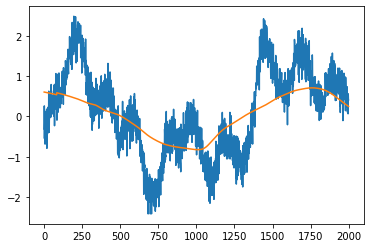

In [66]:
c = 4
plt.plot(data.values[window_len:2000+window_len, 4])
plt.plot(train_pred[:2000, 4].detach().numpy())